<a href="https://colab.research.google.com/github/ELehmann91/Thesis_Multilingual_Transferlearning/blob/master/Results_Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train script
  
using prewritten fuctions and standardized data

In [ ]:
import pandas as pd
from google.colab import drive, files

drive.mount('/content/gdrive')
path ='/content/gdrive/My Drive/Thesis_ecb_ecoicop'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
%%capture
!pip install eli5
!git clone 'https://github.com/ELehmann91/Thesis_Multilingual_Transferlearning'

%cd Thesis_Multilingual_Transferlearning
import labeler_cc5
import coicop_model
import model_helper
import pandas as pd
import numpy as np
from tqdm import tqdm
import io

## Import Data
  
data in the normalized folder are splitted between languages (currently de fr & it) and share the same columns so they can be merged easily

In [ ]:
import pandas as pd
import numpy as np

data_path = '/data/'#
#file_path = 'fra/carrfour_trans_pred.csv'
file_path = 'normalized/norm_fr.csv'
file_path2 = 'normalized/norm_de.csv'
file_path3 = 'at/norm_at.csv'
#file_path = 'edeka_pred.csv'

# french data
df_fr = pd.read_csv(path+data_path+file_path,sep='|',index_col=False)

# only already labeled
df_fr = df_fr[df_fr['cc5'].isna()==False]
df_fr = df_fr[df_fr['shop'].isin( ['carrefour','auchan'])]#,'banque_de_france'])]
df_fr['cc5'] = df_fr['cc5'].apply(lambda x: '9999_Non-Food' if int(str(x)[0])>2 else x)
print(len(df_fr))

# german data
df_de = pd.read_csv(path+data_path+file_path2,sep='|',index_col=False)
# only already labeled
df_de = df_de[df_de['cc5'].isna()==False]
print(len(df_de))
# austrian data
df_at = pd.read_csv(path+data_path+file_path3,sep='|',index_col=False)
# only already labeled
df_at = df_at[df_at['cc5'].isna()==False]
df_de = df_de.append(df_at)
print(len(df_de))

7923
21903
23199


### Exclude non-food?

In [ ]:
no_Classes = 75
exclude_non_food = True
if exclude_non_food:
    df_fr = df_fr[df_fr['cc5']!='9999_Non-Food']
    df_de = df_de[df_de['cc5']!='9999_Non-Food']
    df_at = df_at[df_at['cc5']!='9999_Non-Food']
    no_Classes = 74
    print(len(df_fr))
    print(len(df_de))
    print(len(df_at))

7225
22064
241


decide which columns should be used for training

In [ ]:
var = 'name'
#df_fr['text'] = df_fr[var].fillna('unknown') 
#df_de['text'] = df_de[var].fillna('unknown') 
#df_at['text'] = df_at[var].fillna('unknown') 

var1 = 'categ'
var2 = 'words_from_url'
#df_fr['text'] = df_fr[var1].fillna('unknown')  + ' <sep> ' + df_fr[var2].fillna('unknown') 
#df_de['text'] = df_de[var1].fillna('unknown')  + ' <sep> ' + df_de[var2].fillna('unknown') 
#df_at['text'] = df_at[var1].fillna('unknown')  + ' <sep> ' + df_at[var2].fillna('unknown') 

var1 = 'categ'
var2 = 'words_from_url'
var3 = 'name'
df_fr['text'] = ' <fr> ' + df_fr[var1].fillna('unknown')  + ' <sep> ' + df_fr[var2].fillna('unknown')  + ' <sep> ' + df_fr[var3].fillna('unknown') 
df_de['text'] = ' <de> ' + df_de[var1].fillna('unknown')  + ' <sep> ' + df_de[var2].fillna('unknown')  + ' <sep> ' + df_de[var3].fillna('unknown') 
df_at['text'] = ' <de> ' + df_at[var1].fillna('unknown')  + ' <sep> ' + df_at[var2].fillna('unknown')  + ' <sep> ' + df_at[var3].fillna('unknown') 

#df_fr['text'] = ' <fr> ' + df_fr['name'] + ' <sep> ' + df_fr['categ'].fillna('unknown') + ' <sep> ' + df_fr['words_from_url'].fillna('unknown') + ' <sep> ' + df_fr['prod_desc'].fillna('unknown') 
#df_de['text'] = ' <de> ' + df_de['name'] + ' <sep> ' + df_de['categ'].fillna('unknown') + ' <sep> ' + df_de['words_from_url'].fillna('unknown') + ' <sep> ' + df_de['prod_desc'].fillna('unknown') 
#df_at['text'] = ' <de> ' + df_at['name'] + ' <sep> ' + df_at['categ'].fillna('unknown') + ' <sep> ' + df_at['words_from_url'].fillna('unknown') + ' <sep> ' + df_at['prod_desc'].fillna('unknown') 


In [ ]:
import re
rep_dict = {'.':' ',
                        ',': ' ',
                        '&': ' ',
                        '-': ' ',
                        '/': ' ',
                        'ü': 'ue',
                        'ä': 'ae',
                        'ö': 'oe',
                        'ß': 'ss',
                        'ê': 'e',
                        'é': 'e',
                        'è': 'e',
                        'â': 'a',
                        'á': 'a',
                        'à': 'a',
                        'ô':'o',
                        'œ': 'ae',
                        '%': ' percent ',
                        '1': ' one ',
                        '2': ' two ',
                        '3': ' three ',
                        '4': ' four ',
                        '5': ' five ',
                        '6': ' six ',
                        '7': ' seven ',
                        '8': ' eigth ',
                        '9': ' nine ',
                        '0': ' zero ',
                        ' l ':' liter ',
                        ' ml ':' liter '
                        }

def prepro(line):
    if isinstance(line,str):
        text_str = ' '.join(str(t) for t in line.split())
        text_str = text_str.lower()
        for a,b in rep_dict.items():
            text_str = text_str.replace(a,b)
        text_str = re.sub('[^a-zäöüàáâéèêßœ<>]+', ' ', text_str)
    else: 
        text_str = str(line)
    return text_str

In [ ]:
df_fr['text'] = df_fr['text'].apply(lambda x:prepro(x))
df_de['text'] = df_de['text'].apply(lambda x:prepro(x))
df_at['text'] = df_at['text'].apply(lambda x:prepro(x))

In [ ]:
print('50% quantile no. of words per row french',np.quantile(df_fr['text'].apply(lambda x: len(str(x).split())),.50))
print('50% quantile no. of words per row german',np.quantile(df_de['text'].apply(lambda x: len(str(x).split())),.50))
print('50% quantile no. of words per row austrian',np.quantile(df_at['text'].apply(lambda x: len(str(x).split())),.50))

print('95% quantile no. of words per row french',np.quantile(df_fr['text'].apply(lambda x: len(str(x).split())),.95))
print('95% quantile no. of words per row german',np.quantile(df_de['text'].apply(lambda x: len(str(x).split())),.95))
print('95% quantile no. of words per row austrian',np.quantile(df_at['text'].apply(lambda x: len(str(x).split())),.95))

seq_len = int(max(np.quantile(df_fr['text'].apply(lambda x: len(str(x).split())),.95),np.quantile(df_de['text'].apply(lambda x: len(str(x).split())),.95)))
print('seq_len',seq_len)

50% quantile no. of words per row french 28.0
50% quantile no. of words per row german 19.0
50% quantile no. of words per row austrian 19.0
95% quantile no. of words per row french 39.0
95% quantile no. of words per row german 31.0
95% quantile no. of words per row austrian 26.0
seq_len 39


### Split Train Test

In [ ]:
from sklearn.model_selection import train_test_split
def split_train_abs(df):
    X_train, X_val_test, y_train, y_val_test  = train_test_split(df['text'], df['cc5'], random_state=42, shuffle=True)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test , y_val_test, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train_de, X_val_de, X_test_de, y_train_de, y_val_de, y_test_de = split_train_abs(df_de)
X_train_fr, X_val_fr, X_test_fr, y_train_fr, y_val_fr, y_test_fr = split_train_abs(df_fr)

print('de',X_train_de.shape, X_val_de.shape, X_test_de.shape, y_train_de.shape, y_val_de.shape, y_test_de.shape )
print('fr',X_train_fr.shape, X_val_fr.shape, X_test_fr.shape, y_train_fr.shape, y_val_fr.shape, y_test_fr.shape )

de (16548,) (4137,) (1379,) (16548,) (4137,) (1379,)
fr (5418,) (1355,) (452,) (5418,) (1355,) (452,)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer_de = Tokenizer()
tokenizer_de.fit_on_texts(X_train_de.append(X_val_de).append(X_test_de))
vocab_size_de = len(tokenizer_de.word_index) + 1

tokenizer_fr = Tokenizer()
tokenizer_fr.fit_on_texts(X_train_fr.append(X_val_fr).append(X_test_fr))
vocab_size_fr = len(tokenizer_fr.word_index) + 1

tokenizer_de_fr = Tokenizer()
tokenizer_de_fr.fit_on_texts(X_train_de.append(X_val_de).append(X_test_de).append(X_train_fr).append(X_val_fr).append(X_test_fr))

vocab_size_de_fr = len(tokenizer_de_fr.word_index) + 1
print(vocab_size_de,vocab_size_fr,vocab_size_de_fr)

12969 3996 15624


tokenize & pad

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
#german
X_train_tokens_de = tokenizer_de.texts_to_sequences(X_train_de)
X_val_tokens_de = tokenizer_de.texts_to_sequences(X_val_de)
X_test_tokens_de = tokenizer_de.texts_to_sequences(X_test_de)

X_train_pad_de = pad_sequences(X_train_tokens_de,maxlen=seq_len, padding='post')
X_val_pad_de = pad_sequences(X_val_tokens_de,maxlen=seq_len, padding='post')
X_test_pad_de = pad_sequences(X_test_tokens_de,maxlen=seq_len, padding='post')

#french
X_train_tokens_fr = tokenizer_fr.texts_to_sequences(X_train_fr)
X_val_tokens_fr = tokenizer_fr.texts_to_sequences(X_val_fr)
X_test_tokens_fr = tokenizer_fr.texts_to_sequences(X_test_fr)

X_train_pad_fr = pad_sequences(X_train_tokens_fr,maxlen=seq_len, padding='post')
X_val_pad_fr = pad_sequences(X_val_tokens_fr,maxlen=seq_len, padding='post')
X_test_pad_fr = pad_sequences(X_test_tokens_fr,maxlen=seq_len, padding='post')

In [ ]:
import pickle
french = True
german = True

embedding_dim = 300

if french:
    fr_git_embed = pickle.load( open(path + '/embeddings/fr_slim_embed_ext_voc_share.p', "rb" ) ) #fr_slim_embed_ext #fr_muse_align #fr_muse
    #fr_model = KeyedVectors.load_word2vec_format('/content/gdrive/My Drive/Thesis_ecb_ecoicop/embeddings/wiki.fr.vec')
if german:
    de_git_embed = pickle.load( open(path + '/embeddings/de_slim_embed_ext_voc_share.p', "rb" ) ) #de_muse
    #de_model = KeyedVectors.load_word2vec_format('/content/gdrive/My Drive/Thesis_ecb_ecoicop/embeddings/wiki.de.vec')

v = np.zeros(300)
v[0]=1
fr_git_embed['<sep>'] = v
de_git_embed['<sep>'] = v
v[0]=0
v[1]=1
fr_git_embed['<fr>'] = v
v[1]=-1
de_git_embed['<de>'] = v

print('de_git_embed',len(de_git_embed.keys()))
print('fr_git_embed',len(fr_git_embed.keys()))

X_train_emb_de = np.array(list(model_helper.text_to_embed(X_train_de, ['de' for a in X_train_de], de_git_embed, fr_git_embed, seq_len=seq_len)))
X_val_emb_de = np.array(list(model_helper.text_to_embed(X_val_de, ['de' for a in X_val_de], de_git_embed, fr_git_embed, seq_len=seq_len)))
X_test_emb_de = np.array(list(model_helper.text_to_embed(X_test_de, ['de' for a in X_test_de], de_git_embed, fr_git_embed, seq_len=seq_len)))

X_train_emb_fr = np.array(list(model_helper.text_to_embed(X_train_fr, ['fr' for a in X_train_fr], de_git_embed, fr_git_embed, seq_len=seq_len)))
X_val_emb_fr = np.array(list(model_helper.text_to_embed(X_val_fr, ['fr' for a in X_val_fr], de_git_embed, fr_git_embed, seq_len=seq_len)))
X_test_emb_fr = np.array(list(model_helper.text_to_embed(X_test_fr, ['fr' for a in X_test_fr], de_git_embed, fr_git_embed, seq_len=seq_len)))

print('de',X_train_emb_de.shape, X_val_emb_de.shape, X_test_emb_de.shape)
print('fr',X_train_emb_fr.shape, X_val_emb_fr.shape, X_test_emb_fr.shape)

778it [00:00, 7776.48it/s]

de_git_embed 66952
fr_git_embed 47407


16548it [00:02, 5828.35it/s]
4137it [00:00, 7826.11it/s]
1379it [00:00, 7995.36it/s]
5418it [00:00, 8133.08it/s]
1355it [00:00, 8184.82it/s]
452it [00:00, 8562.67it/s]

de (16548, 39, 300) (4137, 39, 300) (1379, 39, 300)
fr (5418, 39, 300) (1355, 39, 300) (452, 39, 300)


In [ ]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

encoder = LabelEncoder()
encoder.fit(df_de['cc5'])

def encode_label(y_):
    y__ = encoder.transform(y_)
    y_enc =tf.keras.utils.to_categorical(y__, num_classes=no_Classes, dtype="float32")
    return y_enc

y_train_enc_de = encode_label(y_train_de)
y_val_enc_de = encode_label(y_val_de)
y_test_enc_de = encode_label(y_test_de)

y_train_enc_fr = encode_label(y_train_fr)
y_val_enc_fr = encode_label(y_val_fr)
y_test_enc_fr = encode_label(y_test_fr)

print(y_train_enc_de.shape,y_val_enc_de.shape,y_test_enc_de.shape)
print(y_train_enc_fr.shape,y_val_enc_fr.shape,y_test_enc_fr.shape)

(16548, 74) (4137, 74) (1379, 74)
(5418, 74) (1355, 74) (452, 74)


In [ ]:
def get_weigth_dict(y_train):
    weights_dict = dict(zip(y_train.value_counts().index.tolist(),list(len(y_train) / ( len(y_train.unique())  * y_train.value_counts()))))

    class_weight_dict = {}
    for n,lab in enumerate(encoder.classes_):
        try:
            class_weight_dict[n] = weights_dict[lab]
        except:
            class_weight_dict[n] = 1
    return class_weight_dict

class_weight_dict_de = get_weigth_dict(y_train_de)
class_weight_dict_fr = get_weigth_dict(y_train_fr)
class_weight_dict_de_fr = get_weigth_dict(y_train_de.append(y_train_fr))

In [ ]:
def get_embed_matrix(embed,tokenizer,vocab_size,embedding_dim):
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word,i in tokenizer.word_index.items():
        try:
            embedding_matrix[i] = embed[word]
        except KeyError:
            #next
            embedding_matrix[i] = np.random.rand(embedding_dim)
    return embedding_matrix

embedding_matrix_de = get_embed_matrix(de_git_embed,tokenizer_de,vocab_size_de,embedding_dim)
embedding_matrix_fr = get_embed_matrix(fr_git_embed,tokenizer_fr,vocab_size_fr,embedding_dim)

combine_embed = de_git_embed
combine_embed.update(fr_git_embed)
embedding_matrix_de_fr = get_embed_matrix(combine_embed,tokenizer_de_fr,vocab_size_de_fr,embedding_dim)


# Single Language Classifier German

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression

In [ ]:
def tf_idf_log_reg(X_train,y_train,X_test,y_test,no,weights_dict):
    X_train = [str(x).replace('<','').replace('>','') for x in X_train[:no]]
    y_train = y_train[:no]
    X_test = [str(x).replace('<','').replace('>','') for x in X_test]
    vectorizer  = TfidfVectorizer()
    vectorizer.fit(X_train)
    X_train_vec = vectorizer.transform(X_train)
    X_test_vec  = vectorizer.transform(X_test)

    logreg = LogisticRegression(C=1,max_iter=500, solver='newton-cg')#,class_weight=weights_dict)
    logreg.fit(X_train_vec, y_train)

    y_pred_train = logreg.predict(X_train_vec)
    y_pred_test = logreg.predict(X_test_vec)

    print('train obs.',no,'accuracy %s' % accuracy_score(y_pred_train, y_train))
    print('train obs.',no,'b_accuracy %s' % balanced_accuracy_score(y_pred_train, y_train))
    print('test obs.',no,'accuracy %s' % accuracy_score(y_pred_test, y_test))
    print('test obs.',no,'b_accuracy %s' % balanced_accuracy_score(y_pred_test, y_test))
    print()

##LogReg

In [ ]:
tf_idf_log_reg(X_train_de,y_train_de,X_test_de,y_test_de,7500,class_weight_dict_de)

train obs. 7500 accuracy 0.9456
train obs. 7500 b_accuracy 0.9546481414559191
test obs. 7500 accuracy 0.9202320522117476
test obs. 7500 b_accuracy 0.9259442013681677



In [ ]:
stra = False
for obs in [250,500,1000,2000,5000,10000,15000]:
    tf_idf_log_reg(X_train_de,y_train_de,X_test_de,y_test_de,obs,class_weight_dict_de)

train obs. 250 accuracy 0.76
train obs. 250 b_accuracy 0.9159412614675772
test obs. 250 accuracy 0.4517766497461929
test obs. 250 b_accuracy 0.745612749957794

train obs. 500 accuracy 0.83
train obs. 500 b_accuracy 0.9310036284467328
test obs. 500 accuracy 0.6200145032632343
test obs. 500 b_accuracy 0.8089549394473894

train obs. 1000 accuracy 0.877
train obs. 1000 b_accuracy 0.9266222096850557
test obs. 1000 accuracy 0.7781000725163162
test obs. 1000 b_accuracy 0.8242261230614653

train obs. 2000 accuracy 0.903
train obs. 2000 b_accuracy 0.9342202662072603
test obs. 2000 accuracy 0.8462654097171863
test obs. 2000 b_accuracy 0.8539742445884755

train obs. 5000 accuracy 0.9376
train obs. 5000 b_accuracy 0.950819442269889
test obs. 5000 accuracy 0.9050036258158085
test obs. 5000 b_accuracy 0.9104573312399569

train obs. 10000 accuracy 0.9493
train obs. 10000 b_accuracy 0.9530582434314318
test obs. 10000 accuracy 0.9303843364757071
test obs. 10000 b_accuracy 0.9299091047764143

train obs.

## NN

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, GlobalAveragePooling1D, GlobalMaxPooling1D,Concatenate,Embedding,BatchNormalization,Masking,Bidirectional,LSTM,Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2
from keras.utils import np_utils
from gensim.models import KeyedVectors
import pickle
import numpy as np

In [ ]:
 def run_CNN(X_train_pad,y_train_enc,X_val_pad,y_val_enc,X_test_pad,y_test,vocab_size,embedding_matrix,class_weight_dict,no):
    
    dropout_rate=.5
    lr = .005
    opt = Adam(lr=lr, decay=lr/75)

    input_layer = Input(shape = (seq_len,), dtype = 'float')
    embedd_seq = Embedding(vocab_size, embedding_dim, weights = [embedding_matrix], input_length = seq_len, trainable = True, mask_zero=False)(input_layer)
    conv_layer = Conv1D(filters=100,   kernel_size= 5,   padding='valid',  activation='relu', strides=1)(embedd_seq)
    pool_layer = GlobalMaxPooling1D()(conv_layer)
    #pool_layer = GlobalAveragePooling1D()(embedd_seq)
    drop_layer = Dropout(dropout_rate)(pool_layer)
    pred_layer = Dense(y_train_enc.shape[1], activation = 'softmax')(drop_layer) #, kernel_regularizer=l1_l2(0.001)

    avg_pool_mod = Model(inputs = [input_layer], outputs = pred_layer)
    avg_pool_mod.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    early_stopping = EarlyStopping(patience = 5)

    hist = avg_pool_mod.fit(x = X_train_pad[:no], y = y_train_enc[:no],\
                    validation_data = (X_val_pad, y_val_enc), \
                    epochs = 50, batch_size = 256, shuffle = True, class_weight = class_weight_dict, \
                    callbacks = [early_stopping])
    
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
    y_pred_test = avg_pool_mod.predict(X_test_pad)
    y_pred_arg = y_pred_test.argmax(axis=1)
    y_pred_test= [encoder.classes_[y] for y in y_pred_arg]

    print('test obs.',no,'accuracy %s' % accuracy_score(y_pred_test, y_test))
    print('test obs.',no,'b_accuracy %s' % balanced_accuracy_score(y_pred_test, y_test))


In [ ]:
def run_RNN(X_train_pad,y_train_enc,X_val_pad,y_val_enc,X_test_pad,y_test,vocab_size,embedding_matrix,class_weight_dict,no):
    dropout_rate=.5
    lr = .005
    opt = Adam(lr=lr, decay=lr/100)

    input_layer = Input(shape = (seq_len,), dtype = 'int32')
    embedd_seq = Embedding(vocab_size, embedding_dim, weights = [embedding_matrix], input_length = seq_len, trainable = True)(input_layer)
    lstm_layer = Bidirectional(LSTM(128,activation = 'tanh',recurrent_activation = 'sigmoid', dropout = dropout_rate,recurrent_dropout = 0, unroll = False,use_bias = True))(embedd_seq)
    drop_layer = Dropout(dropout_rate)(lstm_layer)
    pred_layer = Dense(y_train_enc.shape[1], activation = 'softmax')(drop_layer) #, kernel_regularizer=l1_l2(0.001)

    avg_pool_mod = Model(inputs = [input_layer], outputs = pred_layer)
    avg_pool_mod.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    early_stopping = EarlyStopping(patience = 5)

    hist = avg_pool_mod.fit(x = X_train_pad[:no], y = y_train_enc[:no],\
                    validation_data = (X_val_pad, y_val_enc), \
                    epochs = 50, batch_size = 256, shuffle = True, class_weight = class_weight_dict, \
                    callbacks = [early_stopping])
    
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
    y_pred_test = avg_pool_mod.predict(X_test_pad)
    y_pred_arg = y_pred_test.argmax(axis=1)
    y_pred_test= [encoder.classes_[y] for y in y_pred_arg]

    print('test obs.',no,'accuracy %s' % accuracy_score(y_pred_test, y_test))
    print('test obs.',no,'b_accuracy %s' % balanced_accuracy_score(y_pred_test, y_test))
    print()

##CNN

In [ ]:
for obs in [500,1000,2000,5000,10000,15000]:
     run_CNN(X_train_pad_de,y_train_enc_de,X_val_pad_de,y_val_enc_de,X_test_pad_de,y_test_de,vocab_size_de,embedding_matrix_de,class_weight_dict_de,obs)


Epoch 1/50
2/2 [==============================] - 0s 226ms/step - loss: 4.7403 - accuracy: 0.0200 - val_loss: 4.2832 - val_accuracy: 0.0268
Epoch 2/50
2/2 [==============================] - 0s 65ms/step - loss: 4.5283 - accuracy: 0.0220 - val_loss: 4.3017 - val_accuracy: 4.8344e-04
Epoch 3/50
2/2 [==============================] - 0s 64ms/step - loss: 4.2381 - accuracy: 0.0260 - val_loss: 4.2790 - val_accuracy: 0.0073
Epoch 4/50
2/2 [==============================] - 0s 62ms/step - loss: 3.8283 - accuracy: 0.0420 - val_loss: 4.1660 - val_accuracy: 0.0201
Epoch 5/50
2/2 [==============================] - 0s 62ms/step - loss: 3.6708 - accuracy: 0.0720 - val_loss: 4.0772 - val_accuracy: 0.0181
Epoch 6/50
2/2 [==============================] - 0s 65ms/step - loss: 3.5575 - accuracy: 0.1100 - val_loss: 3.9934 - val_accuracy: 0.0578
Epoch 7/50
2/2 [==============================] - 0s 65ms/step - loss: 3.3297 - accuracy: 0.1160 - val_loss: 3.8868 - val_accuracy: 0.1020
Epoch 8/50
2/2 [======

## RNN

In [ ]:
for obs in [500,1000,2000,5000,10000,15000]:
    run_RNN(X_train_pad_de,y_train_enc_de,X_val_pad_de,y_val_enc_de,X_test_pad_de,y_test_de,vocab_size_de,embedding_matrix_de,class_weight_dict_de,obs)

Epoch 1/50
2/2 [==============================] - 1s 471ms/step - loss: 4.3586 - accuracy: 0.0100 - val_loss: 4.2455 - val_accuracy: 0.0641
Epoch 2/50
2/2 [==============================] - 0s 87ms/step - loss: 4.2165 - accuracy: 0.0600 - val_loss: 4.1876 - val_accuracy: 0.0440
Epoch 3/50
2/2 [==============================] - 0s 87ms/step - loss: 4.0802 - accuracy: 0.0380 - val_loss: 4.2367 - val_accuracy: 0.0297
Epoch 4/50
2/2 [==============================] - 0s 88ms/step - loss: 3.9580 - accuracy: 0.0640 - val_loss: 3.9544 - val_accuracy: 0.0537
Epoch 5/50
2/2 [==============================] - 0s 90ms/step - loss: 3.7090 - accuracy: 0.1120 - val_loss: 3.9375 - val_accuracy: 0.0467
Epoch 6/50
2/2 [==============================] - 0s 91ms/step - loss: 3.4644 - accuracy: 0.0960 - val_loss: 3.7430 - val_accuracy: 0.0865
Epoch 7/50
2/2 [==============================] - 0s 91ms/step - loss: 3.1574 - accuracy: 0.1600 - val_loss: 3.5104 - val_accuracy: 0.1586
Epoch 8/50
2/2 [==========

# Single Language Classifier French

##LogReg

In [ ]:
stra = False
for obs in [250,500,1000,2000,5000]:
    tf_idf_log_reg(X_train_de,y_train_de,X_test_de,y_test_de,obs,class_weight_dict_de)

train obs. 250 accuracy 0.76
train obs. 250 b_accuracy 0.9159412614675772
test obs. 250 accuracy 0.4517766497461929
test obs. 250 b_accuracy 0.745612749957794

train obs. 500 accuracy 0.83
train obs. 500 b_accuracy 0.9310036284467328
test obs. 500 accuracy 0.6200145032632343
test obs. 500 b_accuracy 0.8089549394473894

train obs. 1000 accuracy 0.877
train obs. 1000 b_accuracy 0.9266222096850557
test obs. 1000 accuracy 0.7781000725163162
test obs. 1000 b_accuracy 0.8242261230614653

train obs. 2000 accuracy 0.903
train obs. 2000 b_accuracy 0.9342202662072603
test obs. 2000 accuracy 0.8462654097171863
test obs. 2000 b_accuracy 0.8539742445884755

train obs. 5000 accuracy 0.9376
train obs. 5000 b_accuracy 0.950819442269889
test obs. 5000 accuracy 0.9050036258158085
test obs. 5000 b_accuracy 0.9104573312399569



##CNN

In [ ]:
for obs in [500,1000,2000,5000]:
     run_CNN(X_train_pad_fr,y_train_enc_fr,X_val_pad_fr,y_val_enc_fr,X_test_pad_fr,y_test_fr,vocab_size_fr,embedding_matrix_fr,class_weight_dict_fr,obs)


Epoch 1/50
2/2 [==============================] - 0s 93ms/step - loss: 5.0520 - accuracy: 0.0120 - val_loss: 4.4206 - val_accuracy: 0.0044
Epoch 2/50
2/2 [==============================] - 0s 34ms/step - loss: 4.7636 - accuracy: 0.0220 - val_loss: 4.2703 - val_accuracy: 0.0177
Epoch 3/50
2/2 [==============================] - 0s 34ms/step - loss: 4.4061 - accuracy: 0.0300 - val_loss: 4.1345 - val_accuracy: 0.0339
Epoch 4/50
2/2 [==============================] - 0s 34ms/step - loss: 4.1948 - accuracy: 0.0620 - val_loss: 4.0397 - val_accuracy: 0.0376
Epoch 5/50
2/2 [==============================] - 0s 34ms/step - loss: 3.9230 - accuracy: 0.1400 - val_loss: 3.9667 - val_accuracy: 0.1395
Epoch 6/50
2/2 [==============================] - 0s 35ms/step - loss: 3.6736 - accuracy: 0.1740 - val_loss: 3.8795 - val_accuracy: 0.1402
Epoch 7/50
2/2 [==============================] - 0s 34ms/step - loss: 3.3229 - accuracy: 0.1880 - val_loss: 3.7137 - val_accuracy: 0.1904
Epoch 8/50
2/2 [===========

## RNN

In [ ]:
for obs in [500,1000,2000,5000]:
     run_RNN(X_train_pad_fr,y_train_enc_fr,X_val_pad_fr,y_val_enc_fr,X_test_pad_fr,y_test_fr,vocab_size_fr,embedding_matrix_fr,class_weight_dict_fr,obs)


Epoch 1/50
2/2 [==============================] - 1s 340ms/step - loss: 4.6244 - accuracy: 0.0180 - val_loss: 4.2526 - val_accuracy: 0.0391
Epoch 2/50
2/2 [==============================] - 0s 48ms/step - loss: 4.5112 - accuracy: 0.0400 - val_loss: 4.2063 - val_accuracy: 0.0347
Epoch 3/50
2/2 [==============================] - 0s 46ms/step - loss: 4.4092 - accuracy: 0.0260 - val_loss: 4.1770 - val_accuracy: 0.0177
Epoch 4/50
2/2 [==============================] - 0s 46ms/step - loss: 4.2259 - accuracy: 0.0320 - val_loss: 4.0182 - val_accuracy: 0.0502
Epoch 5/50
2/2 [==============================] - 0s 47ms/step - loss: 3.8591 - accuracy: 0.0940 - val_loss: 3.7565 - val_accuracy: 0.0841
Epoch 6/50
2/2 [==============================] - 0s 46ms/step - loss: 3.4524 - accuracy: 0.1760 - val_loss: 3.3949 - val_accuracy: 0.2170
Epoch 7/50
2/2 [==============================] - 0s 47ms/step - loss: 3.0487 - accuracy: 0.2620 - val_loss: 3.2167 - val_accuracy: 0.2125
Epoch 8/50
2/2 [==========

# Multilingual Transfer

load embedings  
we only load a "slim" version of the embeddings, which are a subset of the vocab (less than 5%) the time loading the embeddings decreases from 15 min to 7 sec and colab is capable of loading more than two languages (embedding)

### Co2

In [ ]:
!pip install experiment-impact-tracker

     |████████████████████████████████| 10.5MB 2.8MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 92kB 10.3MB/s 
     |████████████████████████████████| 153kB 59.5MB/s 
     |████████████████████████████████| 184kB 59.9MB/s 
     |████████████████████████████████| 102kB 10.7MB/s 
  Created wheel for pylatex: filename=PyLaTeX-1.3.3-cp36-none-any.whl size=42271 sha256=b780c6689e85122396469718f14095e6c8d44d2aeb74561d122757b63c07b818
  Stored in directory: /root/.cache/pip/wheels/22/6c/a7/839041ff582d161a6fc0f3c14c28a16a397a045c7c5059d2bf
  Created wheel for py-cpuinfo: filename=py_cpuinfo-6.0.0-cp36-none-any.whl size=19782 sha256=5f252b22f1ae9856e34f6dc8ca72e8fbe180b4a431028eb8134067518f28694b
  Stored in directory: /root/.cache/pip/wheels/1c/f3/3c/ddcb384c30323d66d842b42f93b6cd2cbdfd1b317237042372
  Created wheel for bootstrapped: filename=bootstrapped-0.0.2-py2.py3-none-any.whl size

In [ ]:
!mkdir logs

In [ ]:
from experiment_impact_tracker.compute_tracker import ImpactTracker
tracker = ImpactTracker('logs')
tracker.launch_impact_monitor()

loading region bounding boxes for computing carbon emissions region, this may take a moment...
 454/454... rate=317.44 Hz, eta=0:00:00, total=0:00:01, wall=16:12 UTC

experiment_impact_tracker.compute_tracker.ImpactTracker - WARNING - Gathering system info for reproducibility...



Done!


experiment_impact_tracker.compute_tracker.ImpactTracker - WARNING - Done initial setup and information gathering...
experiment_impact_tracker.compute_tracker.ImpactTracker - WARNING - Starting process to monitor power


In [ ]:
info = tracker.get_latest_info_and_check_for_errors()

In [ ]:
!ls logs/impacttracker

data.json  impact_tracker_log.log  info.pkl


In [ ]:
!cat logs/impacttracker/impact_tracker_log.log

In [ ]:
!wget 'https://raw.githubusercontent.com/ELehmann91/Thesis_Multilingual_Transferlearning/master/data/model.json'

--2020-06-21 16:12:08--  https://raw.githubusercontent.com/ELehmann91/Thesis_Multilingual_Transferlearning/master/data/model.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 804 [text/plain]
Saving to: ‘model.json’

model.json          100%[===================>]     804  --.-KB/s    in 0s      

2020-06-21 16:12:08 (78.3 MB/s) - ‘model.json’ saved [804/804]



In [ ]:
!create-compute-appendix logs/ --site_spec model.json --output_dir logs/

loading region bounding boxes for computing carbon emissions region, this may take a moment...
 454/454... rate=709.05 Hz, eta=0:00:00, total=0:00:00, wall=16:12 UTC
Done!
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/bin/create-compute-appendix:37: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)
/usr/local/lib/python3.6/dist-packages/experiment_impact_tracker/data_utils.py:26: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  return json_normalize(json_array, max_level=max_level), json_array
Traceback (most recent call last):
  File "/usr/local/bin/create-compute-appendix", line 425, in <module>
   

In [ ]:
class_weight_calc = {}
labels = df_train.cc5.value_counts().index.tolist()
max_class = max(df_train.cc5.value_counts())
for a,b in zip(labels,df_train.cc5.value_counts()):
    class_weight_calc[a] = round(max_class / (b),2)

#labels.append('9999_Non-Food')
labels.sort()

class_weight_dict = {}
for n,lab in enumerate(labels):
  class_weight_dict[n] = class_weight_calc[lab]


NameError: ignored

In [ ]:
weights_dict = dict(zip(df_train.cc5.value_counts().index.tolist(),list(len(df_train.cc5) / ( len(df_train.cc5.unique())  * df_train.cc5.value_counts()))))

class_weight_dict = {}
for n,lab in enumerate(encoder5.classes_):
    try:
        class_weight_dict[n] = weights_dict[lab]
    except:
        class_weight_dict[n] = 1

## Pooling

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense, Bidirectional,LSTM, GlobalAveragePooling1D, Concatenate,Conv1D,BatchNormalization,Add,Masking,GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.regularizers import l1,l2
dropout_rate=.1

input_layer = Input(shape = (seq_len,embedding_dim,), name='text_input')
#mask_layer = Masking(mask_value=0.)(input_layer)
pool_layer = GlobalAveragePooling1D(name='avg_pooling')(input_layer)
#dens_layer = Dense(150, activation='linear', activity_regularizer=l1(0.001),name='dense')(pool_layer)
drop_layer = Dropout(dropout_rate)(pool_layer)
pred_layer_3 = Dense(no_Classes, activation = 'softmax', name='out')(drop_layer) 

de_avg_pool = Model(inputs = [input_layer], outputs = [pred_layer_3])

lr = .03
opt = Adam(lr=lr, decay=lr/100)

de_avg_pool.compile(optimizer = opt, loss = ['categorical_crossentropy'], metrics = ['accuracy'])
early_stopping = EarlyStopping(patience = 5)

hist = de_avg_pool.fit(x = X_train_emb_de, y = y_train_enc_de,\
                validation_data = (X_val_emb_de, y_val_enc_de), \
                epochs = 100, batch_size = 256, shuffle = True, \
                class_weight = class_weight_dict_de, \
                callbacks = [early_stopping])

Epoch 1/100
65/65 [==============================] - 1s 12ms/step - loss: 3.8387 - accuracy: 0.3623 - val_loss: 3.2107 - val_accuracy: 0.5083
Epoch 2/100
65/65 [==============================] - 1s 9ms/step - loss: 3.0712 - accuracy: 0.5916 - val_loss: 2.6202 - val_accuracy: 0.6534
Epoch 3/100
65/65 [==============================] - 1s 10ms/step - loss: 2.5634 - accuracy: 0.6754 - val_loss: 2.1885 - val_accuracy: 0.6998
Epoch 4/100
65/65 [==============================] - 1s 9ms/step - loss: 2.1993 - accuracy: 0.7220 - val_loss: 1.9196 - val_accuracy: 0.7399
Epoch 5/100
65/65 [==============================] - 1s 9ms/step - loss: 1.9397 - accuracy: 0.7523 - val_loss: 1.6983 - val_accuracy: 0.7766
Epoch 6/100
65/65 [==============================] - 1s 10ms/step - loss: 1.7394 - accuracy: 0.7748 - val_loss: 1.5467 - val_accuracy: 0.7904
Epoch 7/100
65/65 [==============================] - 1s 9ms/step - loss: 1.5850 - accuracy: 0.7893 - val_loss: 1.4161 - val_accuracy: 0.8073
Epoch 8/10

In [ ]:
import json
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,balanced_accuracy_score,confusion_matrix
import numpy as np

def test_xy(X,y,string,model):
    y_pred = model.predict([X])
    y_pred_arg = y_pred.argmax(axis=1)
    pred= [encoder.classes_[y] for y in y_pred_arg]
    print('accuracy %s'% string,accuracy_score(pred,y))
    print('b_accuracy %s'%  string,balanced_accuracy_score(pred, y))
    #return pred, y

#test_xy(X_test_emb_de,y_test_de,'together')
test_xy(X_test_emb_de,y_test_de,'german',de_avg_pool)
test_xy(X_test_emb_fr,y_test_fr,'french',de_avg_pool)
#print(classification_report(y,pred))

accuracy german 0.9260333575054387
b_accuracy german 0.8910448143329549
accuracy french 0.36504424778761063
b_accuracy french 0.4336048812722913


Prediction / Certainty Treshold

In [ ]:
def test_xy(X,y,string,model,z,ret=False):
    obs = len(X)
    y_pred = model.predict([X])
    y_pred_arg = y_pred.argmax(axis=1)
    y_pred_max = y_pred.max(axis=1)
    pred= [encoder.classes_[y] for y in y_pred_arg]
    df_pred = pd.DataFrame(zip(X,pred,y,y_pred_max),columns=['embed','pred','y','y_pred_max'])
    df_pred = df_pred[df_pred['y_pred_max']>z]
    print('accuracy %s'% string,accuracy_score(df_pred['pred'],df_pred['y']))
    print('b_accuracy %s'%  string,balanced_accuracy_score(df_pred['pred'],df_pred['y']))
    print(len(df_pred),'of',len(X),int(len(df_pred)/len(X)*100),'%',len(df_pred.pred.unique()))
    if ret:
        return df_pred
test_xy(X_test_emb_de,y_test_de,'german',de_avg_pool,.65)
test_xy(X_train_emb_fr,y_train_fr,'french',de_avg_pool,.8)
    #return pred, y

accuracy german 0.9746606334841629
b_accuracy german 0.959949154161793
1105 of 1379 80 % 71
accuracy french 0.5804274465691789
b_accuracy french 0.6440567609710188
1778 of 5418 32 % 38


Accuracy for higher hirachies

In [ ]:
with open('coicop_5_4.txt') as json_file:#
    coicop_5_4 = json.load(json_file)

with open('coicop_5_3.txt') as json_file:#
    coicop_5_3 = json.load(json_file)

y_pred = de_avg_pool.predict([X_test_emb_fr])
y_pred_arg = y_pred.argmax(axis=1)
pred= [encoder.classes_[y] for y in y_pred_arg]

y_pr_lab3 = [coicop_5_3[cc5] for cc5 in pred]
y_pr_lab4 = [coicop_5_4[cc5] for cc5 in pred]
y_lab3 = [coicop_5_3[cc5] for cc5 in y_test_fr]
y_lab4 = [coicop_5_4[cc5] for cc5 in y_test_fr]
print('accuracy %s'% accuracy_score(y_pr_lab3,y_lab3))
print('b_accuracy %s'%  balanced_accuracy_score(y_pr_lab3, y_lab3))
print('accuracy %s'% accuracy_score(y_pr_lab4,y_lab4))
print('b_accuracy %s'%  balanced_accuracy_score(y_pr_lab4, y_lab4))
#print(classification_report(y_lab4,y_pr_lab4))

accuracy 0.8893805309734514
b_accuracy 0.8502504450055884
accuracy 0.5597345132743363
b_accuracy 0.6232303557160626


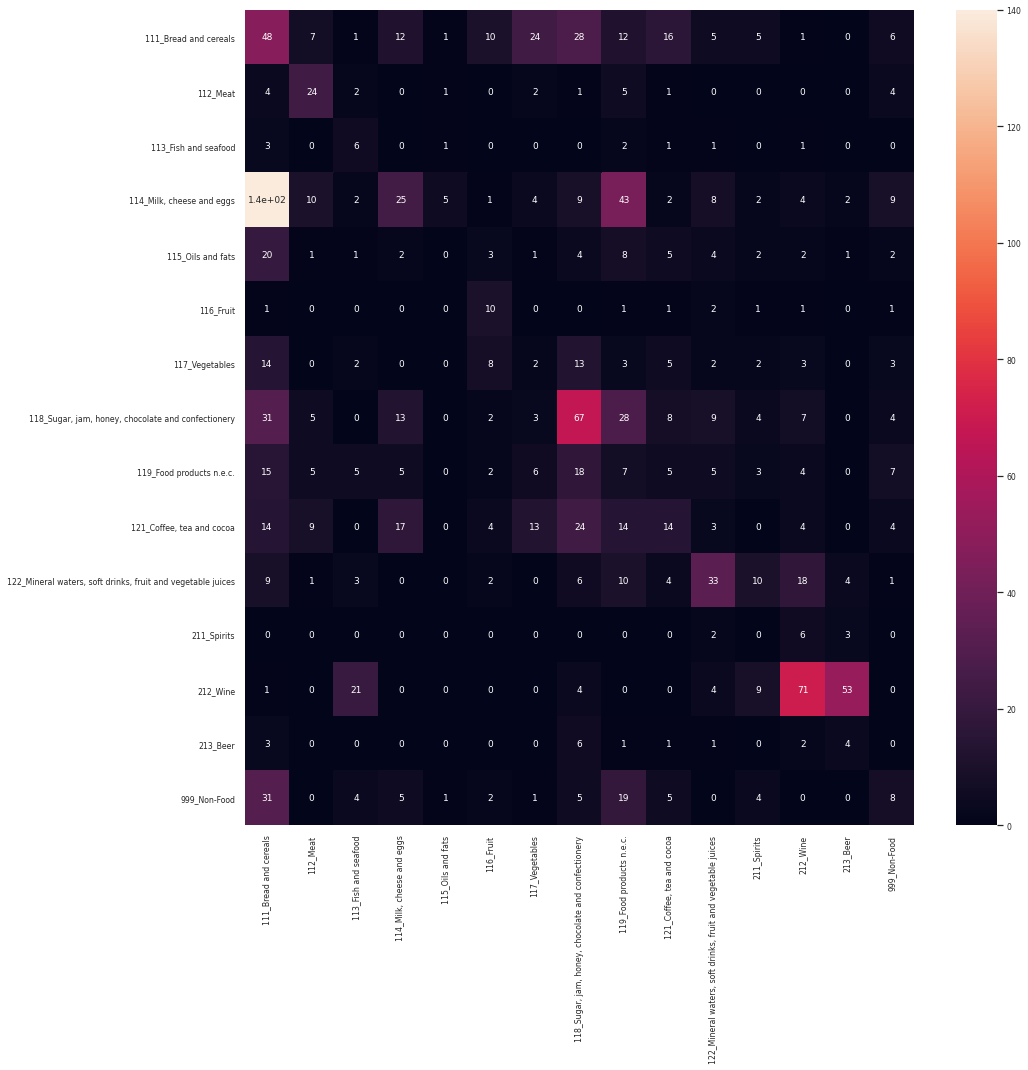

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

y_pred = de_avg_pool.predict([X_test_emb_fr])
y_pred_arg = y_pred.argmax(axis=1)
pred= [encoder.classes_[y] for y in y_pred_arg]

y_pr_lab4 = [coicop_5_4[cc5] for cc5 in pred]
y_lab4 = [coicop_5_4[cc5] for cc5 in y_test_fr]

label = pd.Series(y_lab4).unique()
label.sort()
cm = confusion_matrix(y_lab4,y_pr_lab4,labels=label)#, normalize='true')

df_cm = pd.DataFrame(cm, label,label)
plt.figure(figsize=(15,15))
sn.set(font_scale=.7) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 9}) # font size

plt.show()

## Transferlearning

In [ ]:
few_shot = 5000

dropout_rate=.5
lr = .05
opt = Adam(lr=lr, decay=lr/100)
inp = de_avg_pool.input

# make a new softmax layer with num_classes neurons
#dens_layer_1 = Dense(50, activation='relu',name='dense3')(de_avg_pool.get_layer('dense').output)
drop_layer_1 = Dropout(dropout_rate)(de_avg_pool.layers[-3].output)
out = Dense(no_Classes, activation = 'softmax', name='o3', kernel_regularizer=l1(0.0001))(drop_layer_1) 

# create a new network between inp and out
model_new = Model(inp, out)

# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-2]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-2:]):
    layer.trainable = True

model_new.compile(optimizer = opt, loss = ['categorical_crossentropy'], metrics = ['accuracy'])
early_stopping = EarlyStopping(patience = 5)
model_new.fit(x = X_train_emb_fr[:few_shot], y = y_train_enc_fr[:few_shot],\
                validation_data = (X_val_emb_fr, y_val_enc_fr), \
                epochs = 100, batch_size = 2, shuffle = True, \
                class_weight = class_weight_dict_fr, \
                callbacks = [early_stopping])

Epoch 1/100
2500/2500 [==============================] - 7s 3ms/step - loss: 5.0438 - accuracy: 0.3174 - val_loss: 4.2520 - val_accuracy: 0.5705
Epoch 2/100
2500/2500 [==============================] - 7s 3ms/step - loss: 4.3655 - accuracy: 0.4562 - val_loss: 4.0109 - val_accuracy: 0.6081
Epoch 3/100
2500/2500 [==============================] - 7s 3ms/step - loss: 4.1089 - accuracy: 0.4926 - val_loss: 3.8540 - val_accuracy: 0.5904
Epoch 4/100
2500/2500 [==============================] - 7s 3ms/step - loss: 3.9893 - accuracy: 0.5066 - val_loss: 3.8272 - val_accuracy: 0.6199
Epoch 5/100
2500/2500 [==============================] - 7s 3ms/step - loss: 3.9028 - accuracy: 0.5218 - val_loss: 3.7404 - val_accuracy: 0.6376
Epoch 6/100
2500/2500 [==============================] - 7s 3ms/step - loss: 3.8537 - accuracy: 0.5274 - val_loss: 3.7297 - val_accuracy: 0.6111
Epoch 7/100
2500/2500 [==============================] - 7s 3ms/step - loss: 3.8157 - accuracy: 0.5372 - val_loss: 3.7004 - val_ac

In [ ]:
test_xy(X_test_emb_de,y_test_de,'german',model_new,0)
test_xy(X_test_emb_fr,y_test_fr,'french',model_new,0)

accuracy german 0.11530094271211022
b_accuracy german 0.22278410519151745
1379 of 1379 100 % 16
accuracy french 0.23008849557522124
b_accuracy french 0.38031330797349094
452 of 452 100 % 22


accuracy 0.8230088495575221
b_accuracy 0.8181828785920955


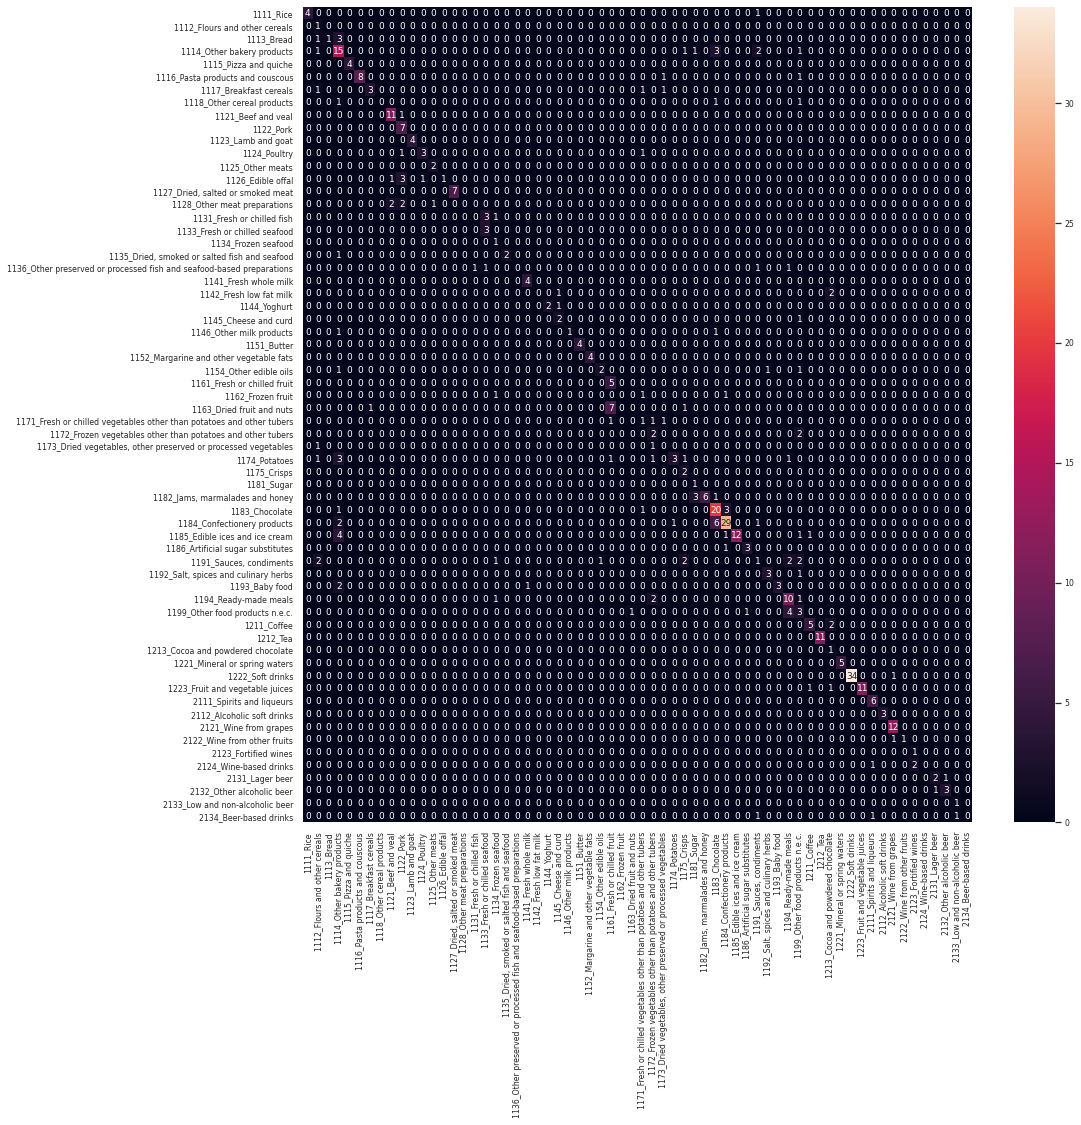

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

y_pred = model_new.predict([X_test_emb_fr])
y_pred_arg = y_pred.argmax(axis=1)
pred= [encoder.classes_[y] for y in y_pred_arg]

y_pr_lab4 = [coicop_5_4[cc5] for cc5 in pred]
y_lab4 = [coicop_5_4[cc5] for cc5 in y_test_fr]
print('accuracy %s'% accuracy_score(y_pr_lab4,y_lab4))
print('b_accuracy %s'%  balanced_accuracy_score(y_pr_lab4, y_lab4))

label = pd.Series(y_test_fr).unique()
label.sort()
cm = confusion_matrix(y_test_fr,pred,labels=label)#, normalize='true')

df_cm = pd.DataFrame(cm, label,label)
plt.figure(figsize=(15,15))
sn.set(font_scale=.7) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 9}) # font size

plt.show()

In [ ]:
test_xy(X_test_emb_de,y_test_de,'german',de_avg_pool_2)
test_xy(X_test_emb_fr,y_test_fr,'french',de_avg_pool_2)

In [ ]:
#print(classification_report(pred, df_acc['cc5']))

2D trial

In [ ]:
class text_to_embed(object):
    '''
    takes text and embeddingmodel as input and outputs sequence of embeddings
    '''
    def __init__(self
                 , text = None
                 , embed_de = None
                 , embed_fr = None
                 , seq_len = None
                 , rep_dict = rep_dict
                 , embedding_dim=300):
                 
        self.text = text
        self.embed_de = embed_de
        self.embed_fr = embed_fr
        self.seq_len = seq_len
        self.embedding_dim = embedding_dim

    def t2s(self,line):
        sen_embed = np.zeros((self.embedding_dim,self.seq_len))
        words = line.split()
        for w in range(0,self.seq_len):
            try: 
                emb_fr = self.embed_fr[words[w]]
                emb_de = self.embed_de[words[w]]
                
            except:
                emb_de = np.zeros(embedding_dim)
                emb_fr = np.zeros(embedding_dim)
            #try: 
            #    emb_fr = self.embed_fr[words[w]]
            #except:
            #    emb_fr = np.zeros(embedding_dim)

            emb_de = np.expand_dims(emb_de, axis=0)
            emb_fr = np.expand_dims(emb_fr, axis=0)

            if w == 0 :
                sen_embed_de = emb_de
                sen_embed_fr = emb_fr
            else:
                sen_embed_de = np.concatenate([sen_embed_de,emb_de],axis=0)
                sen_embed_fr = np.concatenate([sen_embed_fr,emb_fr],axis=0)

        sen_emb = np.stack([sen_embed_de,sen_embed_fr],axis=0)
        return sen_emb #np.array(tokens)

    def t2s_old(self,line):
        #tokens = []
        sen_embed = np.zeros((self.embedding_dim,self.seq_len))
        words = line.split()
        for w in range(0,self.seq_len):
            try: 
              if la == 'de':
                  emb = self.embed_de[words[w]]
              elif la == 'fr':
                  emb = self.embed_fr[words[w]]
              else:
                  print(la)
                  emb = np.zeros(self.embedding_dim)
            except:
                emb = np.zeros(self.embedding_dim)
            #tokens.append(tok)
            sen_embed[:,w] = emb

        sen_embed = np.swapaxes(sen_embed,0,1)
        return sen_embed #np.array(tokens)

    def __iter__(self):
        for line in tqdm(self.text):
            line = self.t2s(line)
            yield line

In [ ]:
X_train_emb_de = np.array(list(text_to_embed(X_train_de,  de_git_embed, fr_git_embed, seq_len=seq_len)))
X_val_emb_de = np.array(list(text_to_embed(X_val_de, de_git_embed, fr_git_embed, seq_len=seq_len)))
X_test_emb_de = np.array(list(text_to_embed(X_test_de, de_git_embed, fr_git_embed, seq_len=seq_len)))

X_train_emb_fr = np.array(list(text_to_embed(X_train_fr, de_git_embed, fr_git_embed, seq_len=seq_len)))
X_val_emb_fr = np.array(list(text_to_embed(X_val_fr, de_git_embed, fr_git_embed, seq_len=seq_len)))
X_test_emb_fr = np.array(list(text_to_embed(X_test_fr, de_git_embed, fr_git_embed, seq_len=seq_len)))

100%|██████████| 452/452 [00:00<00:00, 1134.44it/s]


In [ ]:
print('de',X_train_emb_de.shape, X_val_emb_de.shape, X_test_emb_de.shape)
print('fr',X_train_emb_fr.shape, X_val_emb_fr.shape, X_test_emb_fr.shape)

de (16548, 2, 39, 300) (4137, 2, 39, 300) (1379, 2, 39, 300)
fr (5418, 2, 39, 300) (1355, 2, 39, 300) (452, 2, 39, 300)


In [ ]:
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,GlobalAveragePooling2D,Dropout,Flatten,AveragePooling2D
dropout_rate=.60

input_layer = Input(shape = (2,seq_len,embedding_dim,), name='text_input')
pool_layer = AveragePooling2D(pool_size=(2, 1),name='avg_pooling2')(input_layer)
#conv_layer = Conv2D(150, kernel_size=(10, 3), activation='relu', padding="same")(input_layer)
pool_layer = AveragePooling2D(pool_size=(1, 5),name='avg_pooling3')(pool_layer)
#conv_layer = Conv2D(50, kernel_size=(3, 3), activation='relu', padding="same")(conv_layer)
#conv_layer = AveragePooling2D(pool_size=(1, 3),name='avg_pooling3')(conv_layer)
#mask_layer = Masking(mask_value=0.)(input_layer)
#pool_layer = AveragePooling2D(pool_size=(2, 1),name='avg_pooling')(conv_layer)
pool_layer = Flatten()(pool_layer)
#pool_layer = GlobalAveragePooling2D(name='avg_pooling')(pool_layer)
dens_layer = Dense(150, activation='relu',name='dense')(pool_layer)
drop_layer = Dropout(dropout_rate)(pool_layer)
pred_layer_3 = Dense(no_Classes, activation = 'softmax', name='out')(drop_layer) 

de_avg_pool = Model(inputs = [input_layer], outputs = [pred_layer_3])

lr = .005
opt = Adam(lr=lr, decay=lr/200)
de_avg_pool.summary()
de_avg_pool.compile(optimizer = opt, loss = ['categorical_crossentropy'], metrics = ['accuracy'])
early_stopping = EarlyStopping(patience = 5)

hist = de_avg_pool.fit(x = X_train_emb_de, y = y_train_enc_de,\
                validation_data = (X_val_emb_de, y_val_enc_de), \
                epochs = 100, batch_size = 256, shuffle = True, \
                class_weight = class_weight_dict_de, \
                callbacks = [early_stopping])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 2, 39, 300)]      0         
_________________________________________________________________
avg_pooling2 (AveragePooling (None, 1, 39, 300)        0         
_________________________________________________________________
avg_pooling3 (AveragePooling (None, 1, 7, 300)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2100)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2100)              0         
_________________________________________________________________
out (Dense)                  (None, 74)                155474    
Total params: 155,474
Trainable params: 155,474
Non-trainable params: 0
_____________________________________________________

In [ ]:
import json
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,balanced_accuracy_score,confusion_matrix
import numpy as np

def test_xy(X,y,string,model):
    y_pred = model.predict([X])
    y_pred_arg = y_pred.argmax(axis=1)
    pred= [encoder.classes_[y] for y in y_pred_arg]
    print('accuracy %s'% string,accuracy_score(pred,y))
    print('b_accuracy %s'%  string,balanced_accuracy_score(pred, y))
    #return pred, y

#test_xy(X_test_emb_de,y_test_de,'together')
test_xy(X_test_emb_de,y_test_de,'german',de_avg_pool)
test_xy(X_test_emb_fr,y_test_fr,'french',de_avg_pool)
#print(classification_report(y,pred))

accuracy german 0.9448875997099347
b_accuracy german 0.9182864977317509
accuracy french 0.3252212389380531
b_accuracy french 0.36125857686998997


# Multilingual Training

## CNN

In [ ]:
X_train_emb =  np.concatenate((X_train_emb_de, X_train_emb_fr))
y_train_enc =  np.concatenate((y_train_enc_de, y_train_enc_fr))
X_val_emb =  np.concatenate((X_val_emb_de, X_val_emb_fr))
y_val_enc =  np.concatenate((y_val_enc_de, y_val_enc_fr))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense, Bidirectional, GlobalAveragePooling1D, Concatenate,LSTM,BatchNormalization,Add,Masking,GlobalMaxPooling1D,Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

dropout_rate=.7

input_imbd_1 = Input(shape = (seq_len,embedding_dim,), name='text_input')
mask_layer = Masking(mask_value=0.)(input_imbd_1)
conv_layer = Conv1D(filters=300,   kernel_size= 10,   padding='valid',  activation='relu', strides=1)(input_imbd_1)
conv_layer2 = Conv1D(filters=100,   kernel_size= 5,   padding='valid',  activation='relu', strides=2)(input_imbd_1)
#lstm_layer_1 = Bidirectional(LSTM(128,activation = 'tanh',recurrent_activation = 'sigmoid', dropout = dropout_rate,recurrent_dropout = 0, unroll = False,use_bias = True))(conv_layer)
lstm_layer_1 = GlobalAveragePooling1D()(conv_layer)
#lstm_layer_1 = GlobalMaxPooling1D()(conv_layer)
dens_layer_1 = Dense(100, activation='relu')(lstm_layer_1)
drop_layer_1 = Dropout(dropout_rate)(dens_layer_1)
pred_layer_3 = Dense(74, activation = 'softmax', name='o3')(drop_layer_1) 

de_cnn_avg = Model(inputs = [input_imbd_1], outputs = [pred_layer_3])

lr = .001
opt = Adam(lr=lr, decay=lr/100)

de_cnn_avg.compile(optimizer = opt, loss = ['categorical_crossentropy'], metrics = ['accuracy'])
early_stopping = EarlyStopping(patience = 5)
de_cnn_avg.summary()
hist = de_cnn_avg.fit(x = X_train_emb, y = y_train_enc,\
                validation_data = (X_val_emb, y_val_enc), \
                epochs = 150, batch_size = 64, shuffle = True, \
                class_weight = class_weight_dict_de_fr, \
                callbacks = [early_stopping])

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 39, 300)]         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 30, 300)           900300    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
o3 (Dense)                   (None, 74)                7474      
Total params: 937,874
Trainable params: 937,874
Non-trainable params: 0
_____________________________________________________

In [ ]:
import json
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

def test_xy(X,y,string):
    y_pred = de_cnn_avg.predict([X])
    y_pred_arg = y_pred.argmax(axis=1)
    pred= [encoder.classes_[y] for y in y_pred_arg]
    print('accuracy %s'% string,accuracy_score(pred,y))
    print('b_accuracy %s'%  string,balanced_accuracy_score(pred, y))

test_xy(X_test_emb_de,y_test_de,'german')
test_xy(X_test_emb_fr,y_test_fr,'french')
#print(classification_report(pred, df_test['cc5']))

accuracy german 0.8651196519216824
b_accuracy german 0.7954322955422489
accuracy french 0.32964601769911506
b_accuracy french 0.4953441312279283


In [ ]:
#de_avg_pool
#de_cnn_avg

In [ ]:
# Save the model
#de_cnn_avg.save(path+'/model/de_fr_mod_cc5.h5')

## CNN with training embedding ayer

In [ ]:
X_train_pad =  np.concatenate((X_train_pad_de[3000:9000], X_train_pad_fr[:6000]))
y_train_enc =  np.concatenate((y_train_enc_de[3000:9000], y_train_enc_fr[:6000]))
X_val_pad =  np.concatenate((X_val_pad_de, X_val_pad_fr))
y_val_enc =  np.concatenate((y_val_enc_de, y_val_enc_fr))

In [ ]:


dropout_rate=.6
lr = .001
opt = Adam(lr=lr, decay=lr/100)

input_layer = Input(shape = (seq_len,), dtype = 'float')
embedd_seq = Embedding(vocab_size_de_fr, embedding_dim, weights = [embedding_matrix_de_fr], input_length = seq_len, trainable = True, mask_zero=False)(input_layer)
conv_layer = Conv1D(filters=100,   kernel_size= 5,   padding='valid',  activation='relu', strides=1)(embedd_seq)
pool_layer = GlobalMaxPooling1D(name='max_pool')(conv_layer)
#pool_layer = GlobalAveragePooling1D(name='avg_pooling')(conv_layer)
dens_layer = Dense(150, activation='tanh',name='dense')(pool_layer)
drop_layer = Dropout(dropout_rate)(dens_layer)
pred_layer = Dense(y_train_enc.shape[1], activation = 'softmax')(drop_layer) #, kernel_regularizer=l1_l2(0.001)

cnn_max_pool_mod = Model(inputs = [input_layer], outputs = pred_layer)
cnn_max_pool_mod.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
#print(Ftext_pool.summary())
early_stopping = EarlyStopping(patience = 5)

hist = cnn_max_pool_mod.fit(x = X_train_pad, y = y_train_enc,\
                validation_data = (X_val_pad, y_val_enc), \
                epochs = 50, batch_size = 256, shuffle = True, class_weight = class_weight_dict_de_fr, \
                callbacks = [early_stopping])

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
y_pred_t_de = cnn_max_pool_mod.predict(X_test_pad_de)
y_pred_arg = y_pred_t_de.argmax(axis=1)
y_pred_t_de= [encoder.classes_[y] for y in y_pred_arg]

y_pred_t_fr = cnn_max_pool_mod.predict(X_test_pad_fr)
y_pred_arg = y_pred_t_fr.argmax(axis=1)
y_pred_t_fr= [encoder.classes_[y] for y in y_pred_arg]

print('train obs.','accuracy %s' % accuracy_score(y_pred_t_de, y_test_de))
print('train obs.','b_accuracy %s' % balanced_accuracy_score(y_pred_t_de, y_test_de))
print('train obs.','accuracy %s' % accuracy_score(y_pred_t_fr, y_test_fr))
print('train obs.','b_accuracy %s' % balanced_accuracy_score(y_pred_t_fr, y_test_fr))


Epoch 1/50
45/45 [==============================] - 2s 36ms/step - loss: 4.0271 - accuracy: 0.0871 - val_loss: 3.6397 - val_accuracy: 0.2114
Epoch 2/50
45/45 [==============================] - 1s 33ms/step - loss: 3.2884 - accuracy: 0.2600 - val_loss: 2.8588 - val_accuracy: 0.4701
Epoch 3/50
45/45 [==============================] - 1s 33ms/step - loss: 2.5216 - accuracy: 0.4463 - val_loss: 2.0027 - val_accuracy: 0.6342
Epoch 4/50
45/45 [==============================] - 1s 33ms/step - loss: 1.8970 - accuracy: 0.5856 - val_loss: 1.4224 - val_accuracy: 0.7303
Epoch 5/50
45/45 [==============================] - 1s 33ms/step - loss: 1.4836 - accuracy: 0.6651 - val_loss: 1.0739 - val_accuracy: 0.7802
Epoch 6/50
45/45 [==============================] - 1s 33ms/step - loss: 1.2079 - accuracy: 0.7278 - val_loss: 0.8566 - val_accuracy: 0.8214
Epoch 7/50
45/45 [==============================] - 1s 33ms/step - loss: 1.0086 - accuracy: 0.7673 - val_loss: 0.7117 - val_accuracy: 0.8472
Epoch 8/50
45

## CNN Zero Shot with training embedding layer

In [ ]:
dropout_rate=.7
lr = .001
opt = Adam(lr=lr, decay=lr/100)

input_layer = Input(shape = (seq_len,), dtype = 'float')
embedd_seq = Embedding(vocab_size_de_fr, embedding_dim, weights = [embedding_matrix_de_fr], input_length = seq_len, trainable = True, mask_zero=False)(input_layer)
conv_layer = Conv1D(filters=150,   kernel_size= 7,   padding='valid',  activation='relu', strides=1)(embedd_seq)
pool_layer = GlobalMaxPooling1D(name='max_pool')(conv_layer)
drop_layer = Dropout(dropout_rate)(pool_layer)
pred_layer = Dense(y_train_enc.shape[1], activation = 'softmax')(drop_layer) #, kernel_regularizer=l1_l2(0.001)

cnn_max_pool_mod = Model(inputs = [input_layer], outputs = pred_layer)
cnn_max_pool_mod.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
#print(Ftext_pool.summary())
early_stopping = EarlyStopping(patience = 5)

hist = cnn_max_pool_mod.fit(x = X_train_pad_de, y = y_train_enc_de,\
                validation_data = (X_val_pad_de, y_val_enc_de), \
                epochs = 50, batch_size = 256, shuffle = True, class_weight = class_weight_dict_de_fr, \
                callbacks = [early_stopping])

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
y_pred_t_de = cnn_max_pool_mod.predict(X_test_pad_de)
y_pred_arg = y_pred_t_de.argmax(axis=1)
y_pred_t_de= [encoder.classes_[y] for y in y_pred_arg]

y_pred_t_fr = cnn_max_pool_mod.predict(X_test_pad_fr)
y_pred_arg = y_pred_t_fr.argmax(axis=1)
y_pred_t_fr= [encoder.classes_[y] for y in y_pred_arg]

print('train obs.','accuracy %s' % accuracy_score(y_pred_t_de, y_test_de))
print('train obs.','b_accuracy %s' % balanced_accuracy_score(y_pred_t_de, y_test_de))
print('train obs.','accuracy %s' % accuracy_score(y_pred_t_fr, y_test_fr))
print('train obs.','b_accuracy %s' % balanced_accuracy_score(y_pred_t_fr, y_test_fr))

Epoch 1/50
65/65 [==============================] - 2s 37ms/step - loss: 4.1416 - accuracy: 0.0645 - val_loss: 3.6488 - val_accuracy: 0.3316
Epoch 2/50
65/65 [==============================] - 2s 33ms/step - loss: 3.3337 - accuracy: 0.2572 - val_loss: 2.4957 - val_accuracy: 0.6065
Epoch 3/50
65/65 [==============================] - 2s 32ms/step - loss: 2.2705 - accuracy: 0.4740 - val_loss: 1.3859 - val_accuracy: 0.7462
Epoch 4/50
65/65 [==============================] - 2s 33ms/step - loss: 1.4824 - accuracy: 0.6468 - val_loss: 0.8018 - val_accuracy: 0.8709
Epoch 5/50
65/65 [==============================] - 2s 33ms/step - loss: 1.0349 - accuracy: 0.7571 - val_loss: 0.5378 - val_accuracy: 0.8968
Epoch 6/50
65/65 [==============================] - 2s 34ms/step - loss: 0.7671 - accuracy: 0.8223 - val_loss: 0.4021 - val_accuracy: 0.9239
Epoch 7/50
65/65 [==============================] - 2s 33ms/step - loss: 0.5967 - accuracy: 0.8630 - val_loss: 0.3333 - val_accuracy: 0.9335
Epoch 8/50
65

# Bert

In [ ]:
%%capture
!pip install ktrain

In [ ]:
class_names_ = df_de['cc5'].unique()
class_names_.sort()

In [ ]:
#run_CNN(X_train_pad_de,y_train_enc_de,X_val_pad_de,y_val_enc_de,X_test_pad_de,y_test_de,vocab_size_de,embedding_matrix_de,class_weight_dict_de,obs)


In [ ]:
var1 = 'categ'
var2 = 'words_from_url'
var3 = 'name'
df_fr['text'] = 'fr ' + df_fr[var1].fillna('unknown')  + ' . ' + df_fr[var2].fillna('unknown')  + ' . ' + df_fr[var3].fillna('unknown') 
df_de['text'] = 'de ' + df_de[var1].fillna('unknown')  + ' . ' + df_de[var2].fillna('unknown')  + ' . ' + df_de[var3].fillna('unknown') 
df_at['text'] = 'de ' + df_at[var1].fillna('unknown')  + ' . ' + df_at[var2].fillna('unknown')  + ' . ' + df_at[var3].fillna('unknown') 

from sklearn.model_selection import train_test_split
def split_train_abs(df):
    X_train, X_val_test, y_train, y_val_test  = train_test_split(df['text'], df['cc5'], random_state=42, shuffle=True)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test , y_val_test, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train_de, X_val_de, X_test_de, y_train_de, y_val_de, y_test_de = split_train_abs(df_de)
X_train_fr, X_val_fr, X_test_fr, y_train_fr, y_val_fr, y_test_fr = split_train_abs(df_fr)

print('de',X_train_de.shape, X_val_de.shape, X_test_de.shape, y_train_de.shape, y_val_de.shape, y_test_de.shape )
print('fr',X_train_fr.shape, X_val_fr.shape, X_test_fr.shape, y_train_fr.shape, y_val_fr.shape, y_test_fr.shape )

X_train_de = [str(sen) for sen in X_train_de]
X_val_de = [str(sen) for sen in X_val_de]
X_test_de = [str(sen) for sen in X_test_de]

y_train_de = [str(sen) for sen in y_train_de]
y_val_de = [str(sen) for sen in y_val_de]
y_test_de = [str(sen) for sen in y_test_de]

X_train_fr = [str(sen) for sen in X_train_fr]
X_val_fr = [str(sen) for sen in X_val_fr]
X_test_fr = [str(sen) for sen in X_test_fr]

from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

encoder = LabelEncoder()
encoder.fit(df_de['cc5'])

def encode_label(y_):
    y__ = encoder.transform(y_)
    #y_enc =tf.keras.utils.to_categorical(y__, num_classes=no_Classes, dtype="float32")
    return y__

y_train_enc_de = encode_label(y_train_de)
y_val_enc_de = encode_label(y_val_de)
y_test_enc_de = encode_label(y_test_de)

y_train_enc_fr = encode_label(y_train_fr)
y_val_enc_fr = encode_label(y_val_fr)
y_test_enc_fr = encode_label(y_test_fr)

print(y_train_enc_de.shape,y_val_enc_de.shape,y_test_enc_de.shape)
print(y_train_enc_fr.shape,y_val_enc_fr.shape,y_test_enc_fr.shape)

de (16548,) (4137,) (1379,) (16548,) (4137,) (1379,)
fr (5418,) (1355,) (452,) (5418,) (1355,) (452,)
(16548,) (4137,) (1379,)
(5418,) (1355,) (452,)


In [ ]:
import ktrain
from ktrain import text
MODEL_NAME = 'xlm-roberta-large'#'bert-base-multilingual-cased'
t = text.Transformer(MODEL_NAME, maxlen=60, class_names=class_names_)

trn = t.preprocess_train(X_train_de, y_train_de)
val = t.preprocess_test(X_val_de, y_val_de)
#test = t.preprocess_test(X_test_de, y_test_enc_de)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)


preprocessing train...
language: de
train sequence lengths:
	mean : 19
	95percentile : 30
	99percentile : 33


/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:519: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: de
test sequence lengths:
	mean : 19
	95percentile : 30
	99percentile : 33


In [ ]:
learner.lr_find()
learner.lr_plot()

simulating training for different learning rates... this may take a few moments...
Train for 2758 steps
Epoch 1/1024
 490/2758 [====>.........................] - ETA: 12:38:13 - loss: 4.1394 - accuracy: 0.0646

In [ ]:
learner.fit(5e-5, 5)

Train for 2758 steps, validate for 130 steps
Epoch 1/5
2758/2758 [==============================] - 747s 271ms/step - loss: 3.9799 - accuracy: 0.0537 - val_loss: 3.9709 - val_accuracy: 0.0512
Epoch 2/5
2758/2758 [==============================] - 744s 270ms/step - loss: 3.9777 - accuracy: 0.0532 - val_loss: 3.9703 - val_accuracy: 0.0546
Epoch 3/5
2758/2758 [==============================] - 744s 270ms/step - loss: 3.9772 - accuracy: 0.0520 - val_loss: 3.9716 - val_accuracy: 0.0512
Epoch 4/5
2758/2758 [==============================] - 744s 270ms/step - loss: 3.9759 - accuracy: 0.0534 - val_loss: 3.9696 - val_accuracy: 0.0546
Epoch 5/5
2758/2758 [==============================] - 744s 270ms/step - loss: 3.9765 - accuracy: 0.0551 - val_loss: 3.9724 - val_accuracy: 0.0546


In [ ]:
%%capture
!pip install simpletransformers

In [ ]:
from simpletransformers.classification import ClassificationModel
from simpletransformers.classification import MultiLabelClassificationModel
import pandas as pd
import logging


logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)


train_data = pd.DataFrame(list(zip(X_train_de,y_train_de)), columns =['text','y'])
eval_df = pd.DataFrame(list(zip(X_val_de,y_val_de)), columns =['text','y'])
test_df = pd.DataFrame(list(zip(X_test_de,y_test_de)), columns =['text','y'])

 
# Train and Evaluation data needs to be in a Pandas Dataframe of two columns. The first column is the text with type str, and the second column is the label with type int.
#train_data = [['Example sentence belonging to class 1', 1], ['Example sentence belonging to class 0', 0]]
#train_df = pd.DataFrame(train_data)

#eval_data = [['Example eval sentence belonging to class 1', 1], ['Example eval sentence belonging to class 0', 0]]
#eval_df = pd.DataFrame(eval_data)

# Create a ClassificationModel
model = ClassificationModel('XLM,', 'XLM-RoBERTa') # You can set class weights by using the optional weight argument

# Train the model
model.train_model(train_df)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

ModuleNotFoundError: ignored

get the french

In [ ]:
len(class_names)
Y_FRENCH.shape

In [ ]:
X_FRENCH = list(df_fr['text'])
Y_FRENCH = encode_label(df_fr['cc5'],encoder5)

test = t.preprocess_test(X_FRENCH, Y_FRENCH)
learner.validate(val_data=test, class_names=t.get_classes())

In [ ]:
reloaded_predictor = ktrain.get_predictor(learner.model, preproc=preproc)
reloaded_predictor.predict(X_test[4])

In [ ]:
!pip install transformers
!pip install tensorflow==2.1.0

In [ ]:
import torch
import tensorflow as tf
from transformers import AutoModel, AutoTokenizer, BertTokenizer

torch.set_grad_enabled(False)

In [ ]:
# Store the model we want to use
MODEL_NAME = "bert-base-multilingual-cased"

# We need to create the model and tokenizer
model = AutoModel.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
from transformers import (TFBertForSequenceClassification, 
                          BertTokenizer,
                          TFRobertaForSequenceClassification, 
                          RobertaTokenizer)

bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-multilingual-cased")
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

#roberta_model = TFRobertaForSequenceClassification.from_pretrained("roberta-base")
#roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [ ]:
sequence = "Systolic arrays are cool. This 🐳 is cool too."

bert_tokenized_sequence = bert_tokenizer.tokenize(sequence)

print("BERT:", bert_tokenized_sequence)

BERT: ['Syst', '##oli', '##c', 'array', '##s', 'are', 'cool', '.', 'This', '[UNK]', 'is', 'cool', 'too', '.']


In [ ]:

encoded_bert_sequence = bert_tokenizer.encode(list(X_train_de), add_special_tokens=True, max_length=128)



In [ ]:
df_train = pd.DataFrame(zip(X_train_de , y_train_de),columns=['text','cc5'])
df_train = pd.DataFrame(zip(X_train_de , y_train_de),columns=['text','cc5'])
df_train = pd.DataFrame(zip(X_train_de , y_train_de),columns=['text','cc5'])

In [ ]:
encoded_bert_sequence = bert_tokenizer.encode(list(X_train_de), add_special_tokens=True, max_length=64)

tf_train = tf.data.Dataset.from_tensor_slices((encoded_bert_sequence, df_train['cc5'].values))

ValueError: ignored

In [ ]:
from transformers import glue_convert_examples_to_features

bert_train_dataset = glue_convert_examples_to_features(tf_train, bert_tokenizer, 64, 'mrpc')

TypeError: ignored

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


In [ ]:
print("Fine-tuning BERT on MRPC")
bert_history = bert_model.fit(bert_train_dataset, epochs=3, validation_data=bert_validation_dataset)


In [ ]:
print("Evaluating the BERT model")
bert_model.evaluate(bert_validation_dataset)
